In [2]:
# PREAMBLE
%matplotlib inline

import re
import io
import os.path
from functools import reduce

import pandas as pd

import numpy as np

from ggplot import *

In [3]:
### Network I/O

In [4]:
# PROCESS SAR METRICS
FIND_ETH0 = re.compile(".+ ens3 .+")
FIND_CPU = re.compile(".+ all .+")
BW_COLS = ["ts", "rxpck","txpck","rxkB","txkB"]
CPU_COLS = ["cpu"]
SAMPLES = 5
SAMPLE_RANGE = range(1, SAMPLES+1)

cpu_df = lambda fname: pd.read_fwf(io.StringIO("".join(filter(FIND_CPU.match, open(fname)))), header=None)\
                             .loc[:,[8]]

async_no_ssl_cpus = tuple(cpu_df(os.path.join("reports2", "async_no_ssl_no_sse-cpu.{}.sar.txt".format(i)))
                          for i in SAMPLE_RANGE)
async_yes_ssl_cpus = tuple(cpu_df(os.path.join("reports2", "async_yes_ssl_no_sse-cpu.{}.sar.txt".format(i)))
                           for i in SAMPLE_RANGE)
async_yes_sse_cpus = tuple(cpu_df(os.path.join("reports2", "async_yes_ssl_yes_sse-cpu.{}.sar.txt".format(i)))
                           for i in SAMPLE_RANGE)

for df in async_no_ssl_cpus + async_yes_sse_cpus + async_yes_ssl_cpus:
    df.columns = CPU_COLS

async_no_ssl_cpu = pd.DataFrame({"s{}".format(i): 100-df.cpu for (i,df) in enumerate(async_no_ssl_cpus, 1)})
async_no_ssl_cpu.df_name = "no_ssl_cpu"
async_yes_ssl_cpu = pd.DataFrame({"s{}".format(i): 100-df.cpu for (i,df) in enumerate(async_yes_ssl_cpus, 1)})
async_yes_ssl_cpu.df_name = "yes_ssl_cpu"
async_yes_sse_cpu = pd.DataFrame({"s{}".format(i): 100-df.cpu for (i,df) in enumerate(async_yes_sse_cpus, 1)})
async_yes_sse_cpu.df_name = "yes_sse_cpu"

async_cpu = [async_no_ssl_cpu, async_yes_ssl_cpu, async_yes_sse_cpu]
for i in range(len(async_cpu)):
    df_name = async_cpu[i].df_name
    async_cpu[i]["t"] = async_cpu[i].index
    async_cpu[i] = pd.melt(async_cpu[i], ["t"], var_name="run", value_name=async_cpu[i].df_name)
    async_cpu[i].df_name = df_name

In [5]:
async_cpu_df = pd.melt(reduce(lambda x,y: pd.merge(x, y, on=["t","run"]), async_cpu), 
             id_vars=["t","run"],
             value_name="cpu",
             var_name="run_type",
)

/home/psoutham/.apps/anaconda3/envs/bunnies/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/home/psoutham/.apps/anaconda3/envs/bunnies/lib/python3.5/site-packages/ggplot/stats/stat_smooth.py:22: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  data = data.sort(['x'])
/home/psoutham/.apps/anaconda3/envs/bunnies/lib/python3.5/site-packages/ggplot/components/smoothers.py:67: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=218).std()
  std_err = pd.rolling_std(y, window)
/home/psoutham/.apps/anaconda3/envs/bunnies/lib/python3.5/site-packages/ggplot/components/smoothers.py:68: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=Fa

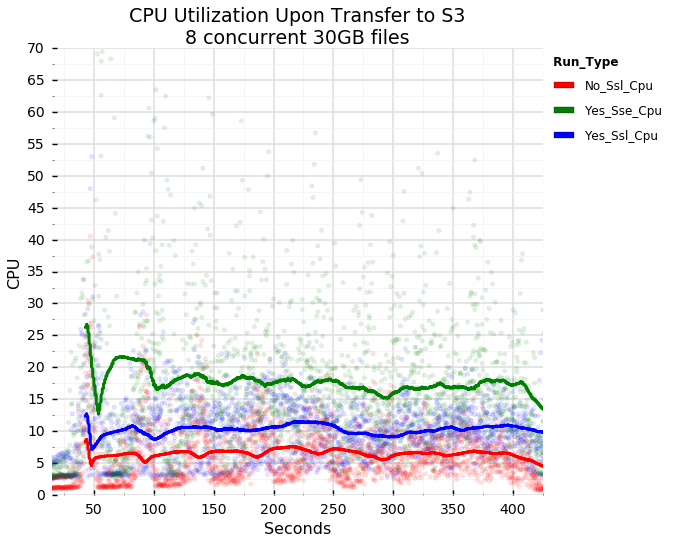

<ggplot: (8755626752765)>

In [82]:
#s = ggplot(aes(x='t', y='cpu', color='run_type', fill='run_type'), data=pd.melt(pd.groupby(async_cpu_df, by=["t","run_type"], exclusions=["run"]).aggregate(np.mean).T, value_name="cpu")) +\
#    geom_line(alpha=1) +\
#    stat_smooth(size=2, span=0.35, alpha=.1) +\
s = ggplot(aes(x='t', y='cpu', color='run_type', fill='run_type'),
           data=async_cpu_df) +\
    stat_smooth(size=3,  alpha=.9, se=False, method="ma") +\
    geom_jitter(alpha=.12) +\
    xlim(15,425) +\
    ylim(0,70) +\
    xlab("Seconds") +\
    ylab("CPU") +\
    ggtitle("CPU Utilization Upon Transfer to S3\n8 concurrent 30GB files") +\
    scale_color_manual(values=["red", "green", "blue"]) +\
    theme_seaborn(context='talk',style="whitegrid")
ggsave("/tmp/network-cpu-1.png",s,dpi=96)
s

/home/psoutham/.apps/anaconda3/envs/bunnies/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
Saving 11.0 x 8.0 in image.


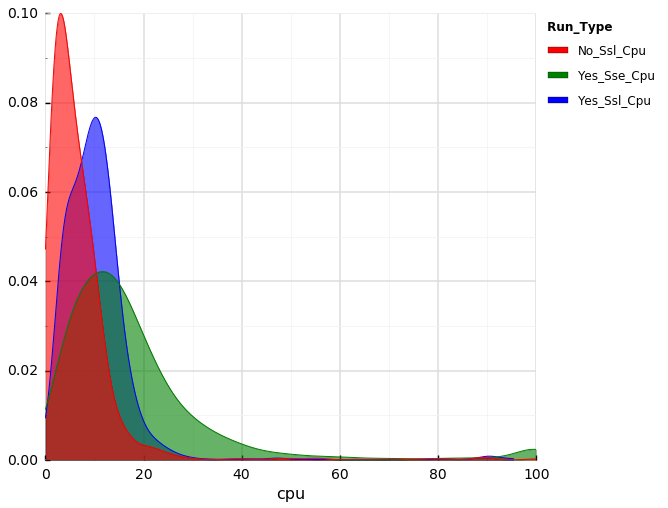

<ggplot: (8755630209477)>

In [7]:
s = ggplot(aes(x='cpu', color='run_type', fill='run_type'), data=async_cpu_df) +\
    geom_density(alpha=.6)+scale_color_manual(values=["red", "green", "blue"]) +\
    theme_seaborn(context='talk',style="whitegrid")
ggsave("/tmp/network-cpu-2.png",s,dpi=96)
s

/home/psoutham/.apps/anaconda3/envs/bunnies/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/home/psoutham/.apps/anaconda3/envs/bunnies/lib/python3.5/site-packages/ggplot/geoms/geom_bar.py:47: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  _reset = self.bottom == None or (self.ax != None and self.ax != ax)
Saving 11.0 x 8.0 in image.


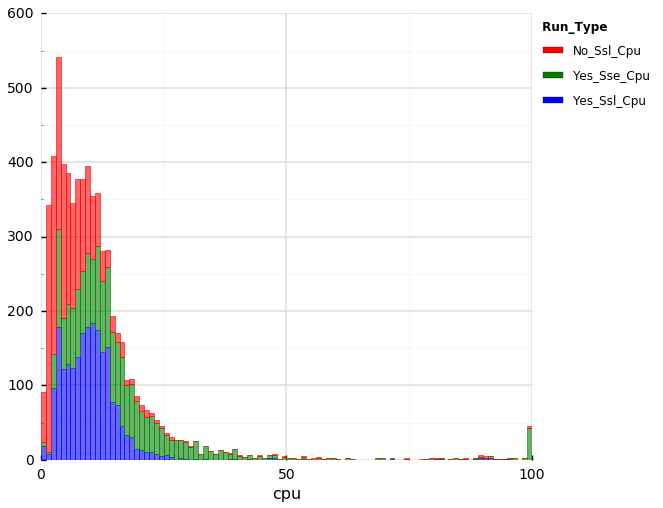

<ggplot: (-9223363281224668149)>

In [8]:
s = ggplot(aes(x='cpu', color='run_type', fill='run_type'), data=async_cpu_df) +\
    geom_histogram(binwidth=1,alpha=.6) +scale_color_manual(values=["red", "green", "blue"]) +\
    theme_seaborn(context='talk',style="whitegrid") + xlim(0,100)
ggsave("/tmp/network-cpu-4.png",s,dpi=96)
s

In [9]:
# PROCESS SAR METRICS
SAMPLES = 8
SAMPLE_RANGE = range(SAMPLES)

single_no_ssl_cpus = tuple(cpu_df(os.path.join("reports2", "single_no_ssl_no_sse-cpu.{}.sar.txt".format(i)))
                          for i in SAMPLE_RANGE)
single_yes_ssl_cpus = tuple(cpu_df(os.path.join("reports2", "single_yes_ssl_no_sse-cpu.{}.sar.txt".format(i)))
                           for i in SAMPLE_RANGE)
single_yes_sse_cpus = tuple(cpu_df(os.path.join("reports2", "single_yes_ssl_yes_sse-cpu.{}.sar.txt".format(i)))
                           for i in SAMPLE_RANGE)

for df in single_no_ssl_cpus + single_yes_sse_cpus + single_yes_ssl_cpus:
    df.columns = CPU_COLS

single_no_ssl_cpu = pd.DataFrame({"s{}".format(i): 100-df.cpu for (i,df) in enumerate(single_no_ssl_cpus)})
single_no_ssl_cpu.df_name = "no_ssl_cpu"
single_yes_ssl_cpu = pd.DataFrame({"s{}".format(i): 100-df.cpu for (i,df) in enumerate(single_yes_ssl_cpus)})
single_yes_ssl_cpu.df_name = "yes_ssl_cpu"
single_yes_sse_cpu = pd.DataFrame({"s{}".format(i): 100-df.cpu for (i,df) in enumerate(single_yes_sse_cpus)})
single_yes_sse_cpu.df_name = "yes_sse_cpu"

single_cpu = [single_no_ssl_cpu, single_yes_ssl_cpu, single_yes_sse_cpu]

for i in range(len(single_cpu)):
    df_name = single_cpu[i].df_name
    single_cpu[i]["t"] = single_cpu[i].index
    single_cpu[i] = pd.melt(single_cpu[i], ["t"], var_name="run", value_name=single_cpu[i].df_name)
    single_cpu[i].df_name = df_name

In [10]:
single_cpu_df = pd.melt(reduce(lambda x,y: pd.merge(x, y, on=["t","run"]), single_cpu), 
             id_vars=["t","run"],
             value_name="cpu",
             var_name="run_type",
)

/home/psoutham/.apps/anaconda3/envs/bunnies/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/home/psoutham/.apps/anaconda3/envs/bunnies/lib/python3.5/site-packages/ggplot/stats/stat_smooth.py:22: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  data = data.sort(['x'])
/home/psoutham/.apps/anaconda3/envs/bunnies/lib/python3.5/site-packages/ggplot/components/smoothers.py:67: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=105).std()
  std_err = pd.rolling_std(y, window)
/home/psoutham/.apps/anaconda3/envs/bunnies/lib/python3.5/site-packages/ggplot/components/smoothers.py:68: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=Fa

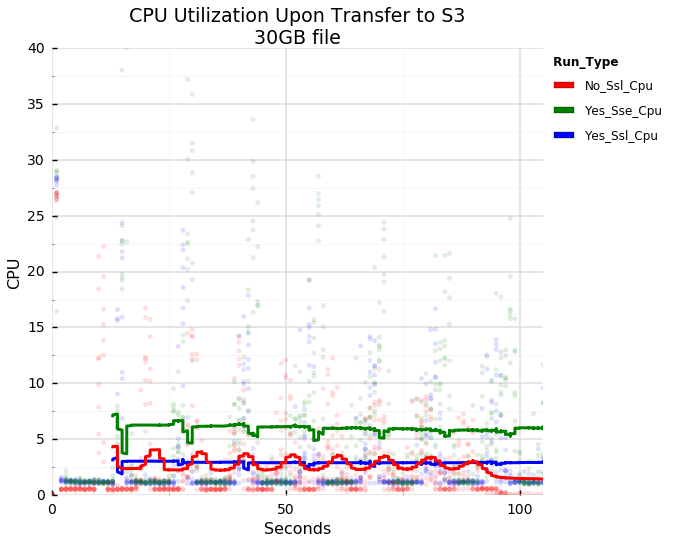

<ggplot: (8755626443847)>

In [83]:
#pd.melt(single_cpu_df[["t", "run_type","cpu"]].groupby(["t", "run_type"]).mean().T, value_name="cpu"))
s = ggplot(aes(x='t', y='cpu', color='run_type', fill='run_type'),
           data=single_cpu_df) +\
    stat_smooth(size=3,  alpha=.9, se=False, method="ma", window=105) +\
    geom_jitter(alpha=.12) +\
    xlim(0,105) +\
    ylim(0,40) +\
    xlab("Seconds") +\
    ylab("CPU") +\
    ggtitle("CPU Utilization Upon Transfer to S3\n30GB file") +\
    scale_color_manual(values=["red", "green", "blue"]) +\
    theme_seaborn(context='talk', style="whitegrid")
#ggsave("/tmp/single-network-cpu-1.png", s, dpi=96)
s

In [45]:
single_cpu_df[single_cpu_df.run_type=="yes_sse_cpu"].mean()

t      52.500000
cpu     6.170908
dtype: float64

/home/psoutham/.apps/anaconda3/envs/bunnies/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
Saving 11.0 x 8.0 in image.


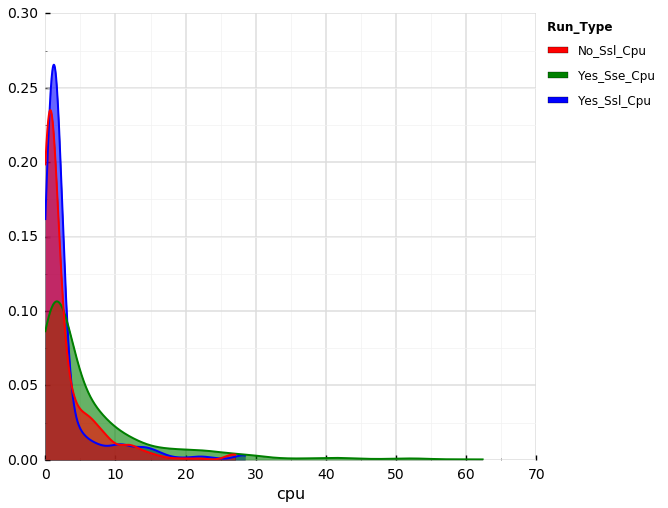

<ggplot: (-9223363281224732002)>

In [12]:
s = ggplot(aes(x='cpu', fill="run_type", color='run_type'), data=single_cpu_df) +\
    geom_density(alpha=.6, size=2)+scale_color_manual(values=["red", "green", "blue"])+\
    theme_seaborn(context='talk',style="whitegrid")
ggsave("/tmp/single-network-cpu-3.png",s,dpi=96)
s

/home/psoutham/.apps/anaconda3/envs/bunnies/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/home/psoutham/.apps/anaconda3/envs/bunnies/lib/python3.5/site-packages/ggplot/geoms/geom_bar.py:47: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  _reset = self.bottom == None or (self.ax != None and self.ax != ax)
Saving 11.0 x 8.0 in image.


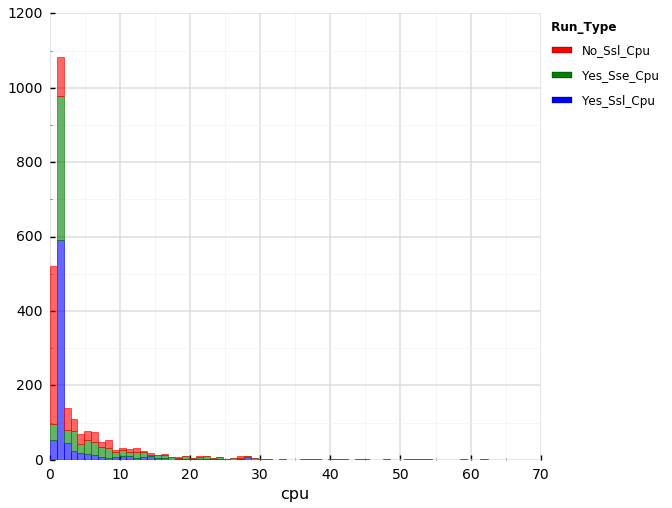

<ggplot: (8755626868407)>

In [13]:
s = ggplot(aes(x='cpu',  color='run_type',fill='run_type'), data=single_cpu_df) +\
    geom_histogram(binwidth=1,alpha=.6)+scale_color_manual(values=["red", "green", "blue"])+\
    theme_seaborn(context='talk',style="whitegrid")
ggsave("/tmp/single-network-cpu-4.png",s,dpi=96)
s

### Disk I/O

In [14]:
samples = []
for dev in ("eph-p", "eph-e", "io-e", "io-p"): #"gpt-e", 
    with open(os.path.join("reports", "bonnie.{}.txt".format(dev)), "r") as f:
        samples.extend(dev.split("-") + l.strip().split(",") for l in f.readlines()[1:])

In [15]:
bonnie = pd.DataFrame(samples)[[0,1,11, 12, 13,17, 18, 39, 40,]+list(range(42,50))]
bonnie.columns=["dev_type", "enc_flag", "put_block", "put_block_cpu", "rewrite", "get_block",
"get_block_cpu", "put_block_latency","rewrite_latency",
"get_block_latency","seeks_latency","seq_create_latency","seq_stat_latency","seq_del_latency","ran_create_latency","ran_stat_latency","ran_del_latency"]

for l in ("put_block", "get_block", "put_block_cpu", "get_block_cpu"):
    bonnie[l] = bonnie[l].apply(int)
    
for l in ("put_block_latency", "get_block_latency"):
    bonnie[l] = bonnie[l].apply(lambda x: int(x[:-2]) if x[-2:] == "us" else int(x[:-2])*1000)

In [16]:
bonnie.head()

,dev_type,enc_flag,put_block,put_block_cpu,rewrite,get_block,get_block_cpu,put_block_latency,rewrite_latency,get_block_latency,seeks_latency,seq_create_latency,seq_stat_latency,seq_del_latency,ran_create_latency,ran_stat_latency,ran_del_latency
0,eph,p,439625,28,180121,439533,14,22803,458ms,20886,4909us,136ms,274us,347ms,152ms,41us,282ms
1,eph,p,440489,29,181749,439541,14,26011,378ms,15698,389us,138ms,272us,253ms,138ms,49us,287ms
2,eph,p,433757,28,178483,439745,14,26556,403ms,9400,575us,154ms,447us,215ms,137ms,47us,244ms
3,eph,p,406842,27,178898,439132,14,38160,404ms,21083,2004us,141ms,272us,231ms,162ms,49us,301ms
4,eph,p,407786,27,180905,428006,13,28688,432ms,21548,1731us,155ms,272us,300ms,150ms,48us,289ms


/home/psoutham/.apps/anaconda3/envs/bunnies/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
Saving 11.0 x 8.0 in image.


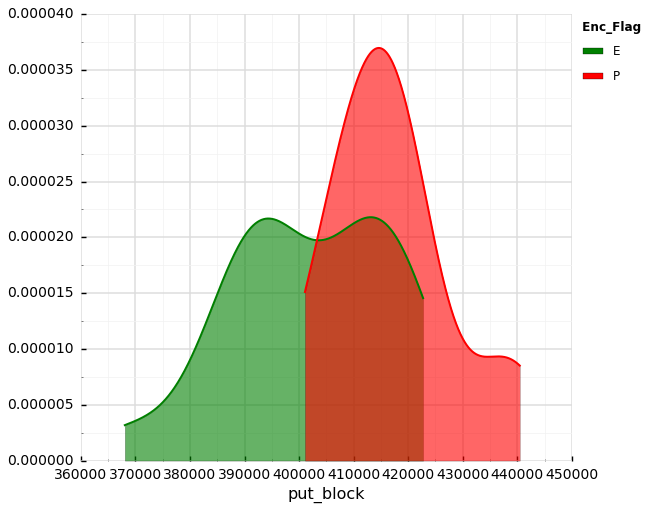

<ggplot: (8755629961820)>

In [17]:
s = ggplot(aes(x="put_block", color="enc_flag",fill="enc_flag"), data=bonnie[bonnie.dev_type == "eph"]) +\
    geom_density(alpha=.6, size=2) +scale_color_manual(values=["green", "red"])+\
    theme_seaborn(context='talk',style="whitegrid")
ggsave("/tmp/disk-io-1.png",s,dpi=96)
s

/home/psoutham/.apps/anaconda3/envs/bunnies/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/home/psoutham/.apps/anaconda3/envs/bunnies/lib/python3.5/site-packages/ggplot/ggplot.py:200: RuntimeWarning: Facetting is currently not supported with geom_bar. See
                    https://github.com/yhat/ggplot/issues/196 for more information
  warnings.warn(msg, RuntimeWarning)
stat_bin: binwidth defaulted to range/30.
    Use 'binwidth = x' to adjust this.
/home/psoutham/.apps/anaconda3/envs/bunnies/lib/python3.5/site-packages/ggplot/geoms/geom_bar.py:47: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  _reset = self.bottom == None or (self.ax != None and self.ax != ax)
Saving 11.0 x 8.0 in image.


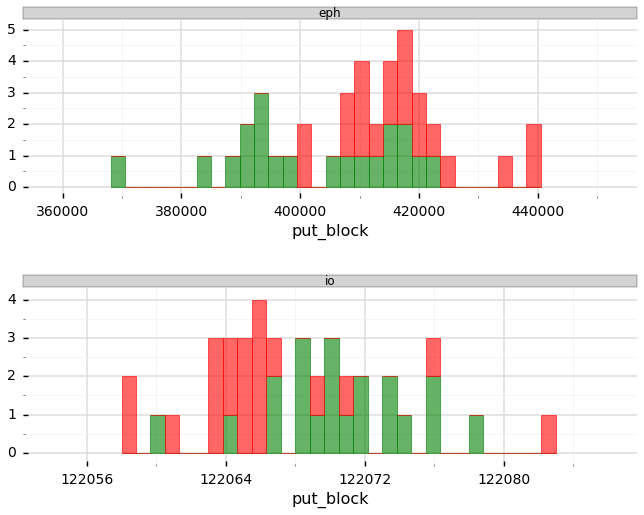

<ggplot: (8755630133277)>

In [18]:
s = ggplot(aes(x="put_block", color="enc_flag", fill="enc_flag"), data=bonnie) +\
    geom_histogram(alpha=.6) +\
    facet_wrap("dev_type") +scale_color_manual(values=["green", "red"])+\
    theme_seaborn(context='talk',style="whitegrid")
ggsave("/tmp/disk-io-2.png",s,dpi=96)
s

/home/psoutham/.apps/anaconda3/envs/bunnies/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
Saving 11.0 x 8.0 in image.


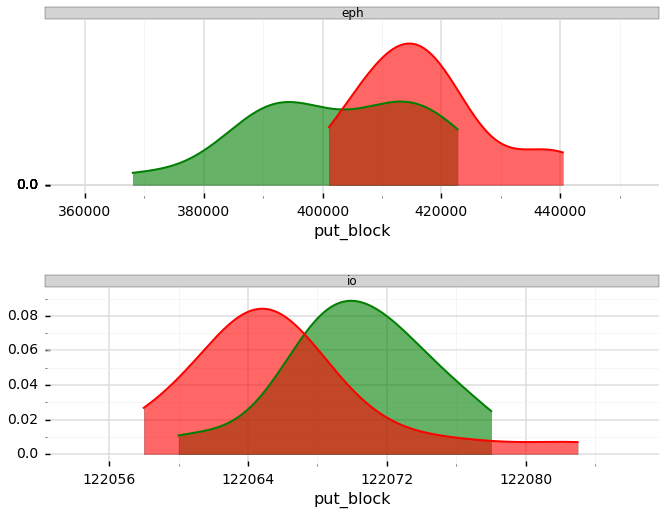

<ggplot: (-9223363281228081755)>

In [19]:
s = ggplot(aes(x="put_block", color="enc_flag", fill="enc_flag"), data=bonnie) +\
    geom_density(alpha=.6, size=2) +\
    facet_wrap("dev_type")+scale_color_manual(values=["green", "red"])+\
    theme_seaborn(context='talk',style="whitegrid")
ggsave("/tmp/disk-io-3.png",s,dpi=96)
s

/home/psoutham/.apps/anaconda3/envs/bunnies/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/home/psoutham/.apps/anaconda3/envs/bunnies/lib/python3.5/site-packages/ggplot/ggplot.py:200: RuntimeWarning: Facetting is currently not supported with geom_bar. See
                    https://github.com/yhat/ggplot/issues/196 for more information
  warnings.warn(msg, RuntimeWarning)
/home/psoutham/.apps/anaconda3/envs/bunnies/lib/python3.5/site-packages/ggplot/geoms/geom_bar.py:47: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  _reset = self.bottom == None or (self.ax != None and self.ax != ax)
Saving 11.0 x 8.0 in image.


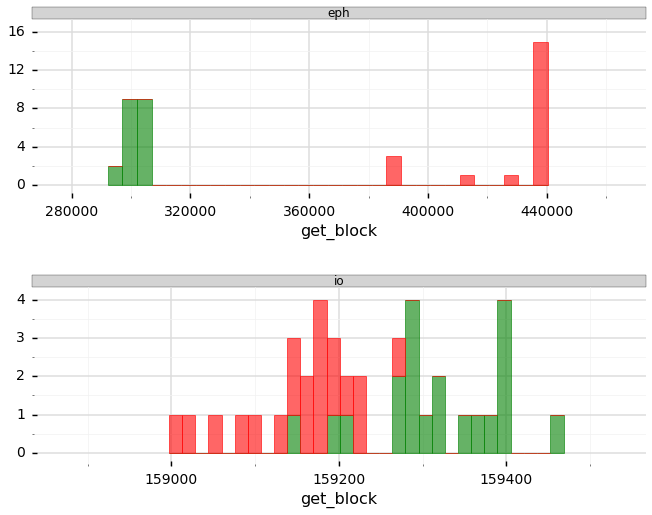

<ggplot: (-9223363281225225009)>

In [20]:
s = ggplot(aes(x="get_block", color="enc_flag", fill="enc_flag"), data=bonnie) +\
    geom_histogram(alpha=.6) + facet_wrap("dev_type") +scale_color_manual(values=["green", "red"])+\
    theme_seaborn(context='talk',style="whitegrid")
ggsave("/tmp/disk-io-4.png",s,dpi=96)
s

/home/psoutham/.apps/anaconda3/envs/bunnies/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
Saving 11.0 x 8.0 in image.


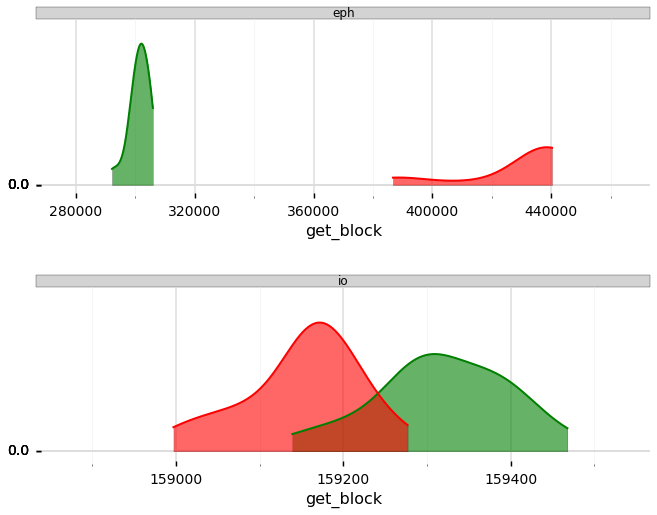

<ggplot: (-9223363281249371178)>

In [21]:
s = ggplot(aes(x="get_block", color="enc_flag", fill="enc_flag"), data=bonnie)+\
    geom_density(alpha=.6, size=2) +\
    facet_wrap("dev_type") + scale_color_manual(values=["green", "red"])+\
    theme_seaborn(style="whitegrid",context='talk')
ggsave("/tmp/disk-io-5.png",s,dpi=96)
s